In [1]:
# Uncomment the following lines to install the required packages if needed
# %pip install pymannkendall
# %pip install Jinja2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import pymannkendall as mk
from matplotlib.colors import LinearSegmentedColormap

Source of the dataset of this project is the following link:

https://www.kaggle.com/datasets/wisekinder/poland-air-quality-monitoring-dataset-2017-2023

After downloading the dataset, put the unzipped data in the correct directory to run the code. 

In [3]:
# path to the downloaded data files, change it to your own path
path = '/Users/aleksandra/Documents/UNI/environmental_data_project_1'

# folder of interest
# folder_of_interest = 'joint_data_2017-2023.csv'

# path to the folder of interest
data_dir = path + '/'

# dictionary of the datasets of interest
datasets = {
    "CO_data": 'CO_1g_joint_2017-2023.csv',
    "NOx_data": 'NOx_1g_joint_2017-2023.csv',
    "PM10_data": 'PM10_1g_joint_2017-2023.csv',
    "PM25_data": 'PM25_1g_joint_2017-2023.csv',
    "SO2_data": 'SO2_1g_joint_2017-2023.csv'
}

### Data pre-processing

In [4]:
for name, file in datasets.items():
    data = pd.read_csv(data_dir + file)
    print(f"{name} shape: {data.shape}")

CO_data shape: (61345, 114)
NOx_data shape: (61345, 220)
PM10_data shape: (61345, 273)
PM25_data shape: (61345, 161)
SO2_data shape: (61345, 170)


In [5]:
for name, file in datasets.items():
    data = pd.read_csv(data_dir + file)
    
    # Filter columns that contain 'Krak' which stands for Krakow, a city in the south of Poland
    krak_columns = [col for col in data.columns if 'Krak' in col]
    
    if krak_columns:
        print(f"\nIn {name}, columns containing 'Krak':")
        for col in krak_columns:
            missing_count = data[col].isna().sum()
            print(f"  {col}: {missing_count} missing values")
    else:
        print(f"\nIn {name}, no columns containing 'Krak'.")


In CO_data, columns containing 'Krak':
  MpKrakAlKras-CO-1g: 9491 missing values
  MpKrakBulwar-CO-1g: 1046 missing values

In NOx_data, columns containing 'Krak':
  MpKrakAlKras-NOx-1g: 9383 missing values
  MpKrakBujaka-NOx-1g: 1581 missing values
  MpKrakBulwar-NOx-1g: 1201 missing values
  MpKrakDietla-NOx-1g: 522 missing values

In PM10_data, columns containing 'Krak':
  MpKrakAlKras-PM10-1g: 9411 missing values
  MpKrakBujaka-PM10-1g: 1816 missing values
  MpKrakBulwar-PM10-1g: 999 missing values
  MpKrakDietla-PM10-1g: 1300 missing values
  MpKrakOsPias-PM10-1g: 2844 missing values
  MpKrakTelime-PM10-1g: 49135 missing values
  MpKrakWadow-PM10-1g: 889 missing values
  MpKrakZloRog-PM10-1g: 1263 missing values
  MpKrakSwoszo-PM10-1g: 18885 missing values

In PM25_data, columns containing 'Krak':
  MpKrakAlKras-PM2.5-1g: 9407 missing values
  MpKrakBujaka-PM2.5-1g: 35740 missing values
  MpKrakBulwar-PM2.5-1g: 1000 missing values

In SO2_data, columns containing 'Krak':
  MpKrak

We see that AlKras, Bulwar and Bujaka are the most commonly found weather stations. Now:  
- AlKras is missing from SO2_data
- Bujaka has too many missing values in PM25_data (more than half).

__Let's try AlKras and Bulwar on CO_data, NOx_data, PM10_data and PM25_data.__

In [6]:
datasets_of_interest = ["CO_data", "NOx_data", "PM10_data", "PM25_data"]
results = []

for name in datasets_of_interest:
    file = datasets[name]
    data = pd.read_csv(data_dir + file)
    
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    if krak_columns:
        for col in krak_columns:
            missing_count = data[col].isna().sum()
            total_count = len(data[col])
            
            percentage_missing = (missing_count / total_count) * 100 if total_count > 0 else 0
            
            results.append({
                "Dataset": name,
                "Column": col,
                "Missing Values": missing_count,
                "Percentage": f"{percentage_missing:.2f}%"
            })
    
results_df = pd.DataFrame(results)

if not results_df.empty:
    print(results_df)
else:
    print("No columns containing 'MpKrakAlKras' or 'MpKrakBulwar' found in the specified datasets.")

     Dataset                 Column  Missing Values Percentage
0    CO_data     MpKrakAlKras-CO-1g            9491     15.47%
1    CO_data     MpKrakBulwar-CO-1g            1046      1.71%
2   NOx_data    MpKrakAlKras-NOx-1g            9383     15.30%
3   NOx_data    MpKrakBulwar-NOx-1g            1201      1.96%
4  PM10_data   MpKrakAlKras-PM10-1g            9411     15.34%
5  PM10_data   MpKrakBulwar-PM10-1g             999      1.63%
6  PM25_data  MpKrakAlKras-PM2.5-1g            9407     15.33%
7  PM25_data  MpKrakBulwar-PM2.5-1g            1000      1.63%


We see that the missing data percentage is quite low, so since we have really large data sets, we are going to remove all the rows where the values are missing.

In [7]:
# path to saving the cleaned data, by default it is the data folder from cloned repository
data_out = './data/'

In [8]:
# for name in datasets_of_interest:
#     file = datasets[name]
#     data = pd.read_csv(data_dir + file)
    
#     # Find columns that contain 'MpKrakAlKras' or 'MpKrakBulwar'
#     krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

#     if krak_columns:
#         # Remove rows where any of the specified columns have NaN values
#         cleaned_data = data.dropna(subset=krak_columns)
        
#         cleaned_data.to_csv(data_out + f'cleaned_{name}.csv', index=False)
        
#         print(f"Cleaned {name}: {cleaned_data.shape[0]} rows remaining after removing NaN values.")
#     else:
#         print(f"No columns containing 'MpKrakAlKras' or 'MpKrakBulwar' found in {name}.")

In [9]:
for name in datasets_of_interest:
    file = datasets[name]
    data = pd.read_csv(data_dir + file)
    
    # Check data types before further processing
    print(f"Data types for {name} before cleaning:")
    print(data.dtypes)
    
    # Convert the 'Time' column to datetime, if necessary
    if 'Time' in data.columns and data['Time'].dtype != 'datetime64[ns]':
        data['Time'] = pd.to_datetime(data['Time'], errors='coerce')  # Convert to datetime, coerce errors to NaT

    # Ensure numerical columns are of the correct type
    for col in data.columns:
        if col != 'Time' and data[col].dtype not in ['int64', 'float64']:
            data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric, coerce errors to NaN

    # Set 'Time' as the index after conversion
    data.set_index('Time', inplace=True)

    # Find columns that contain 'MpKrakAlKras' or 'MpKrakBulwar'
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    if krak_columns:
        # Filter only the relevant columns
        relevant_data = data[krak_columns]

        # Remove rows where any of the specified columns have NaN values
        cleaned_data = relevant_data.dropna()

        # Save the cleaned data containing only MpKrakAlKras and MpKrakBulwar columns
        cleaned_data.to_csv(data_out + f'cleaned_{name}_KrakStations.csv', index=True)
        
        print(f"Cleaned and saved {name} with only relevant columns: {cleaned_data.shape[0]} rows remaining.")
    else:
        print(f"No columns containing 'MpKrakAlKras' or 'MpKrakBulwar' found in {name}.")


Data types for CO_data before cleaning:
Time                      object
DsBoleslaMOB-CO-1g       float64
DsJelGorOgin-CO-1g       float64
DsKudowaMOB-CO-1g        float64
DsLegAlRzecz-CO-1g       float64
                          ...   
LbZamoHrubie-CO-1g       float64
OpOpoleOsAKr-CO-1g       float64
PdBialAlPils-CO-1g       float64
SkWloszKilinMOB-CO-1g    float64
WpPoznSzwajc-CO-1g       float64
Length: 114, dtype: object
Cleaned and saved CO_data with only relevant columns: 50925 rows remaining.
Data types for NOx_data before cleaning:
Time                       object
DsBoleslaMOB-NOx-1g       float64
DsCzerStraza-NOx-1g       float64
DsDzialoszyn-NOx-1g       float64
DsDziePilsud-NOx-1g       float64
                           ...   
PmLebMalczew-NOx-1g       float64
SkWloszKilinMOB-NOx-1g    float64
WmKetrWojPolMOB-NOx-1g    float64
WpPoznSzwajc-NOx-1g       float64
ZpSwinMatejkMOB-NOx-1g    float64
Length: 220, dtype: object
Cleaned and saved NOx_data with only relevant column

The values in all columns are all floats so we are good to proceed with analysing the data.

In [10]:
cleaned_datasets = {
    "CO_data": 'cleaned_CO_data_KrakStations.csv',
    "NOx_data": 'cleaned_NOx_data_KrakStations.csv',
    "PM10_data": 'cleaned_PM10_data_KrakStations.csv',
    "PM25_data": 'cleaned_PM25_data_KrakStations.csv',
}

### Summary statistics

In [11]:
summary_stats_dict = {}

for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_out + file)
    
    # Find columns that contain 'MpKrakAlKras' or 'MpKrakBulwar'
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    summary_stats = []

    # Calculate summary statistics for each relevant column
    for col in krak_columns:
        stats = data[col].describe()
        summary_stats.append({
            'Statistic': 'Mean', 
            'Value': stats['mean'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Standard deviation', 
            'Value': stats['std'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Min', 
            'Value': stats['min'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': '25th percentile', 
            'Value': stats['25%'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Median', 
            'Value': stats['50%'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': '75th percentile', 
            'Value': stats['75%'],
            'Column': col
        })
        summary_stats.append({
            'Statistic': 'Max', 
            'Value': stats['max'],
            'Column': col
        })

    # Create a DataFrame from the summary statistics
    summary_df = pd.DataFrame(summary_stats)
    summary_df_pivot = summary_df.pivot(index='Statistic', columns='Column', values='Value')
    summary_stats_dict[name] = summary_df_pivot

# Display the summary statistics tables for each dataset
for dataset, stats_table in summary_stats_dict.items():
    print(f"\nSummary Statistics for {dataset}:")
    stats_table.columns.name = ''
    display(stats_table.style
        .set_table_attributes('style="font-size: 12px; border-collapse: collapse; width: 50%;"')
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#f5f5f5'), ('font-weight', 'bold'), ('border', '1px solid #dddddd'), ('max-width', '100px')]},  # Set max-width for headers
            {'selector': 'td', 'props': [('border', '1px solid #dddddd'), ('max-width', '100px')]}  # Set max-width for cells
        ])
    )


Summary Statistics for CO_data:


,MpKrakAlKras-CO-1g,MpKrakBulwar-CO-1g
Statistic,,
25th percentile,0.487550,0.219640
75th percentile,0.891970,0.509820
Max,6.212260,6.416360
Mean,0.755683,0.430141
Median,0.639870,0.330090
Min,0.101120,0.018390
Standard deviation,0.416339,0.349616



Summary Statistics for NOx_data:


,MpKrakAlKras-NOx-1g,MpKrakBulwar-NOx-1g
Statistic,,
25th percentile,83.998500,16.850600
75th percentile,210.207500,56.354600
Max,1340.630000,967.868000
Mean,163.366046,49.881328
Median,137.223000,29.860700
Min,5.672270,2.228540
Standard deviation,115.113106,62.271617



Summary Statistics for PM10_data:


,MpKrakAlKras-PM10-1g,MpKrakBulwar-PM10-1g
Statistic,,
25th percentile,23.565500,15.694200
75th percentile,56.420250,41.663750
Max,415.450000,382.054000
Mean,46.075368,34.109582
Median,35.698100,24.795000
Min,1.000000,1.000000
Standard deviation,36.182031,30.127835



Summary Statistics for PM25_data:


,MpKrakAlKras-PM2.5-1g,MpKrakBulwar-PM2.5-1g
Statistic,,
25th percentile,12.767775,8.588437
75th percentile,35.773450,28.247000
Max,341.088000,329.693000
Mean,29.535831,23.234632
Median,20.896100,15.446300
Min,1.000000,0.900000
Standard deviation,27.756325,24.128311


### Time-series plots

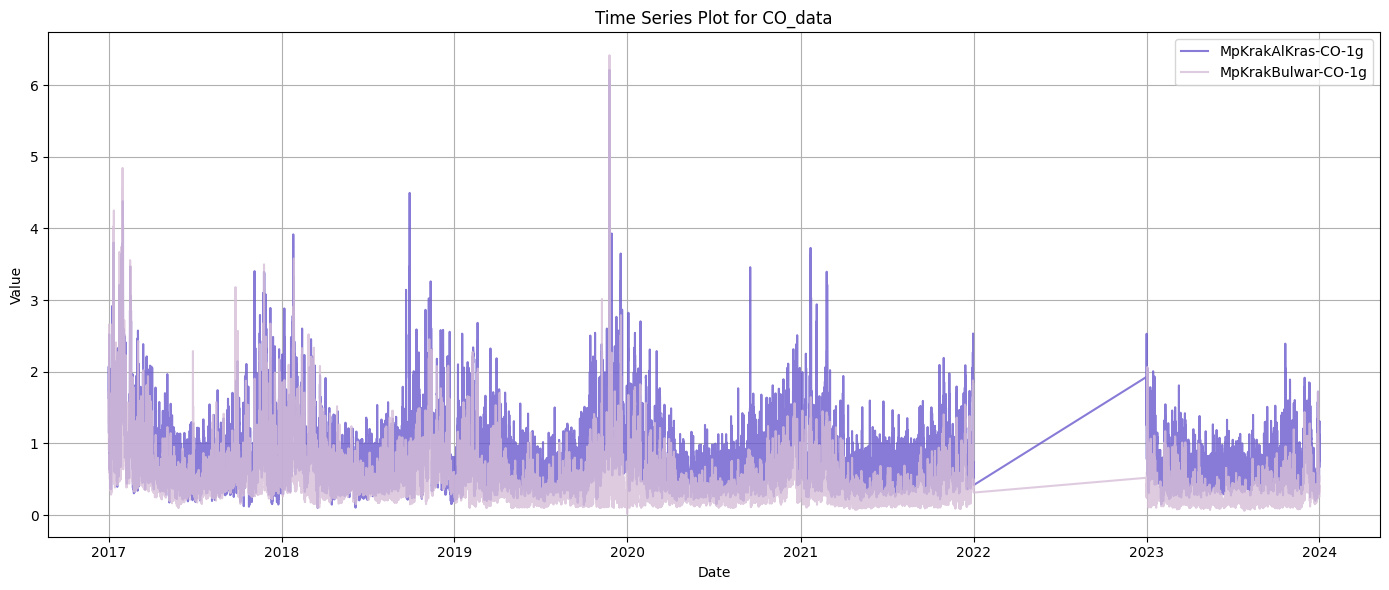

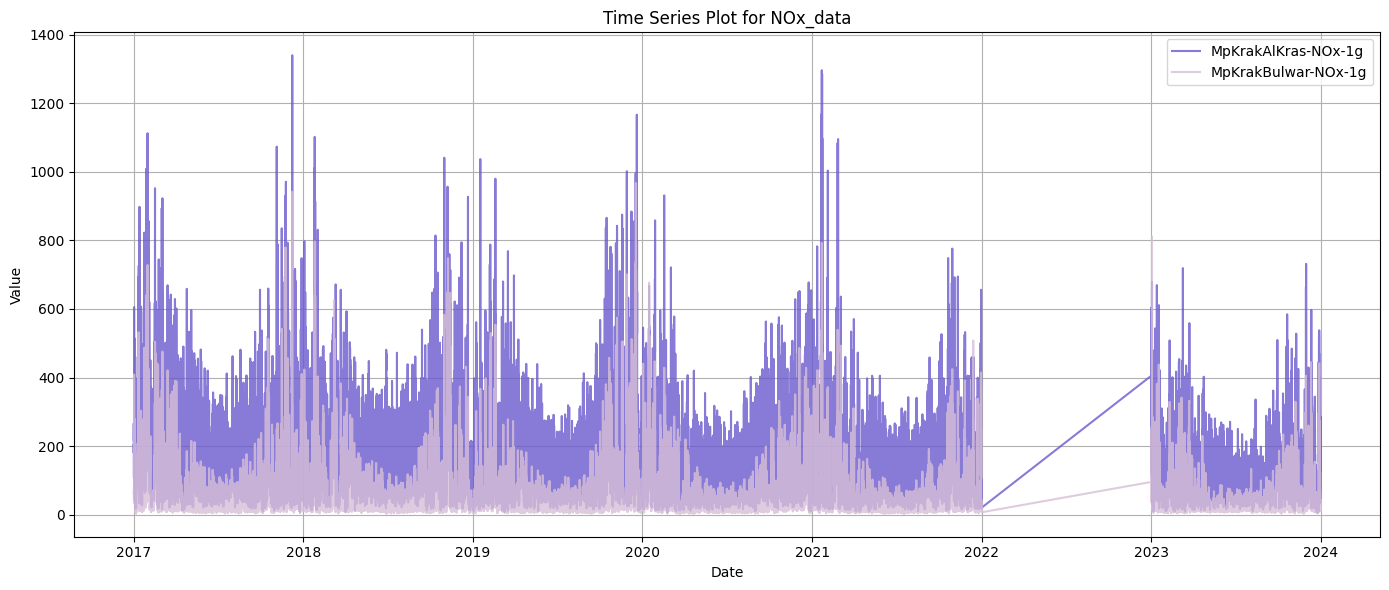

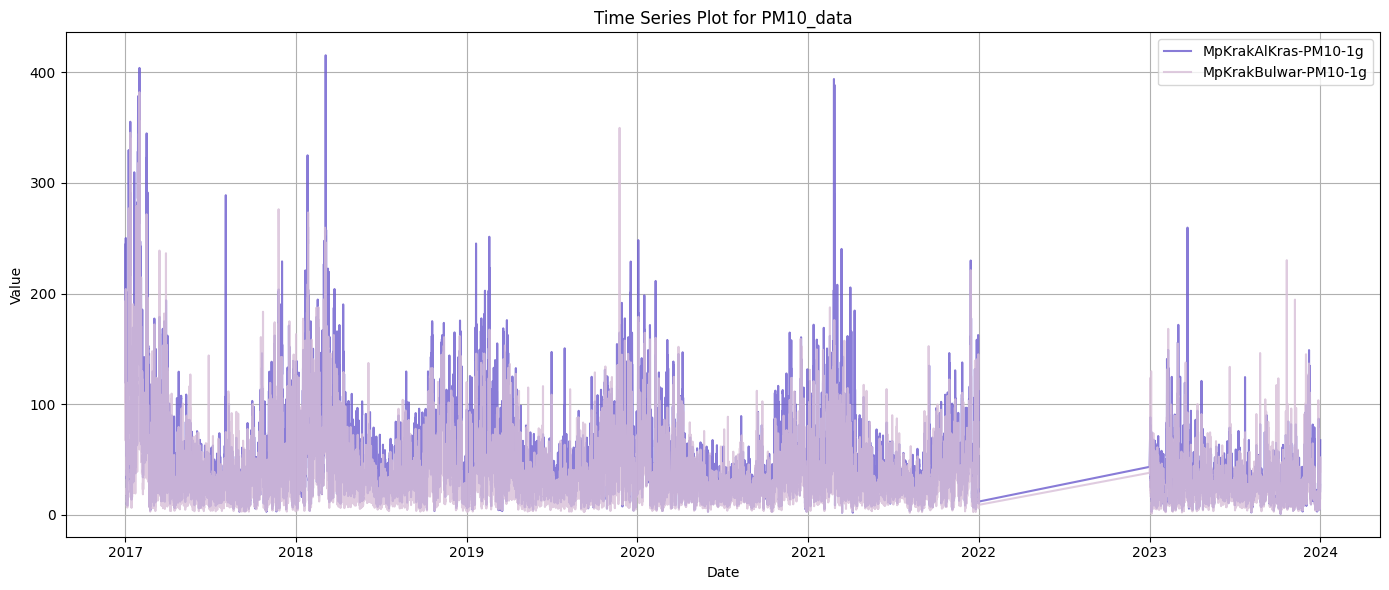

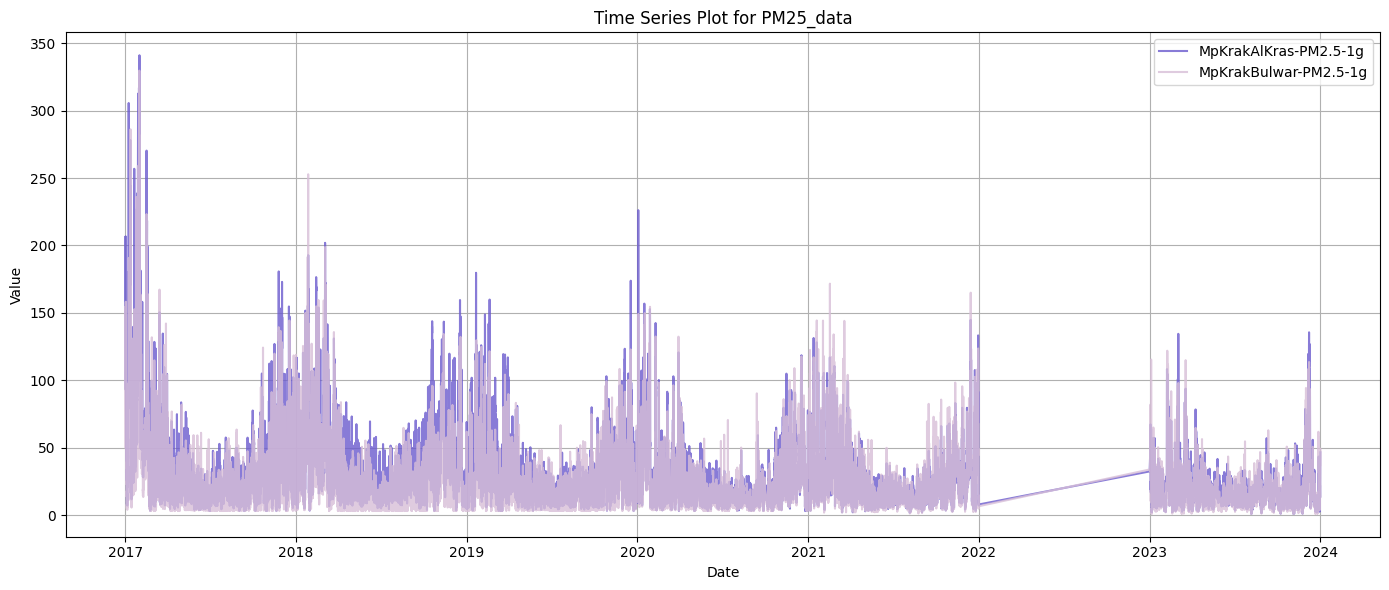

In [12]:
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_out + file)
    
    data['date_column'] = pd.to_datetime(data['Time']) 
    data.set_index('date_column', inplace=True) 

    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    plt.figure(figsize=(14, 6))
    
    for col in krak_columns:
        if 'MpKrakAlKras' in col:
            color = 'slateblue'
        elif 'MpKrakBulwar' in col:
            color = 'thistle'
        
        plt.plot(data.index, data[col], label=col, color=color, alpha=0.8)
        
    plt.title(f'Time Series Plot for {name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    plt.show()

There seems to be a gap between 2022 and 2023, which could mean that for some reason, the entire year 2022 was not recorded. Therefore, we will focus our study on the period 01/01/2017 - 31/12/2021.

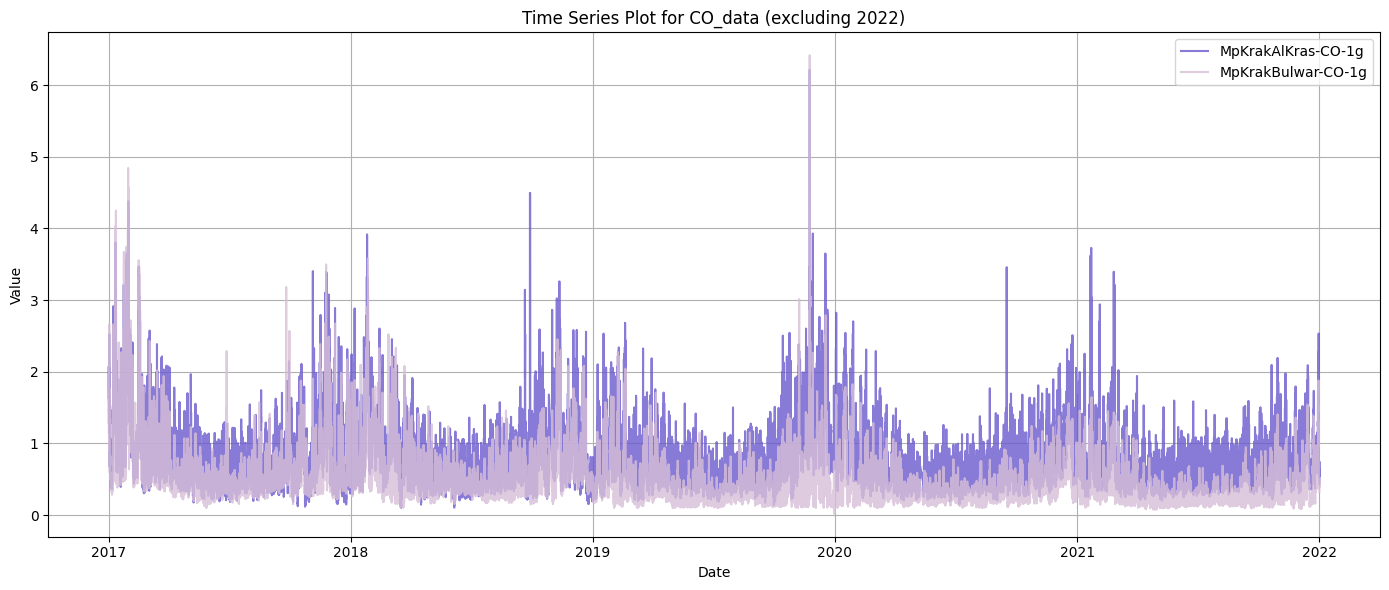

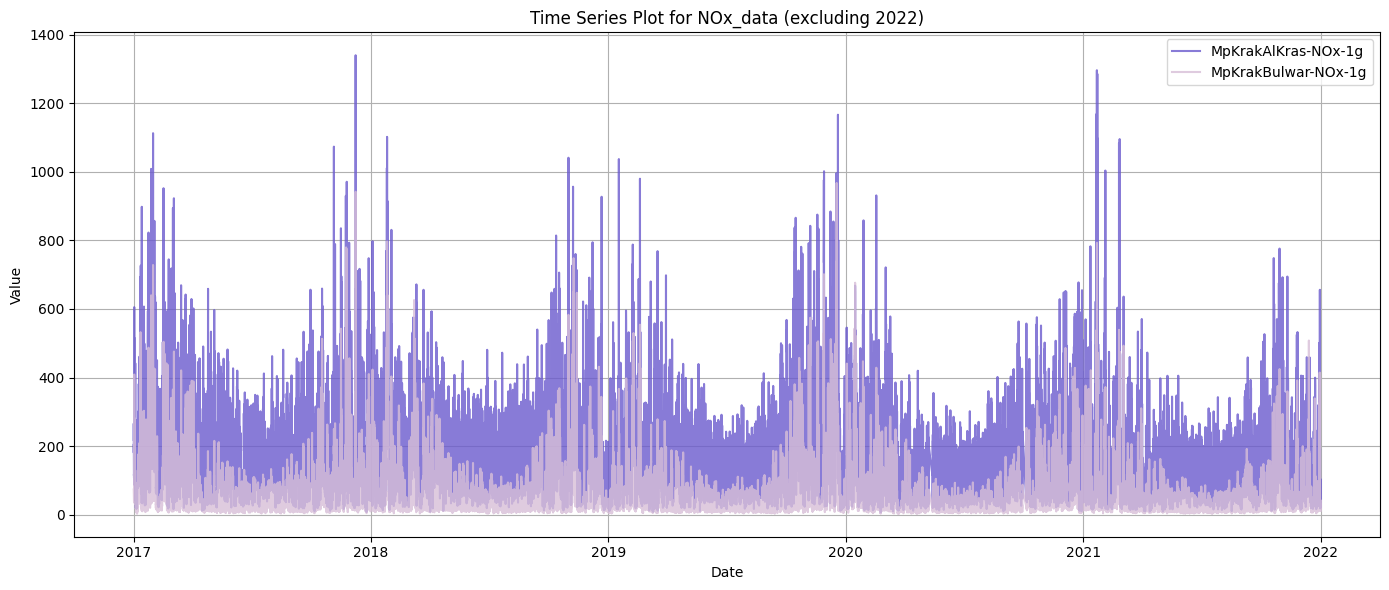

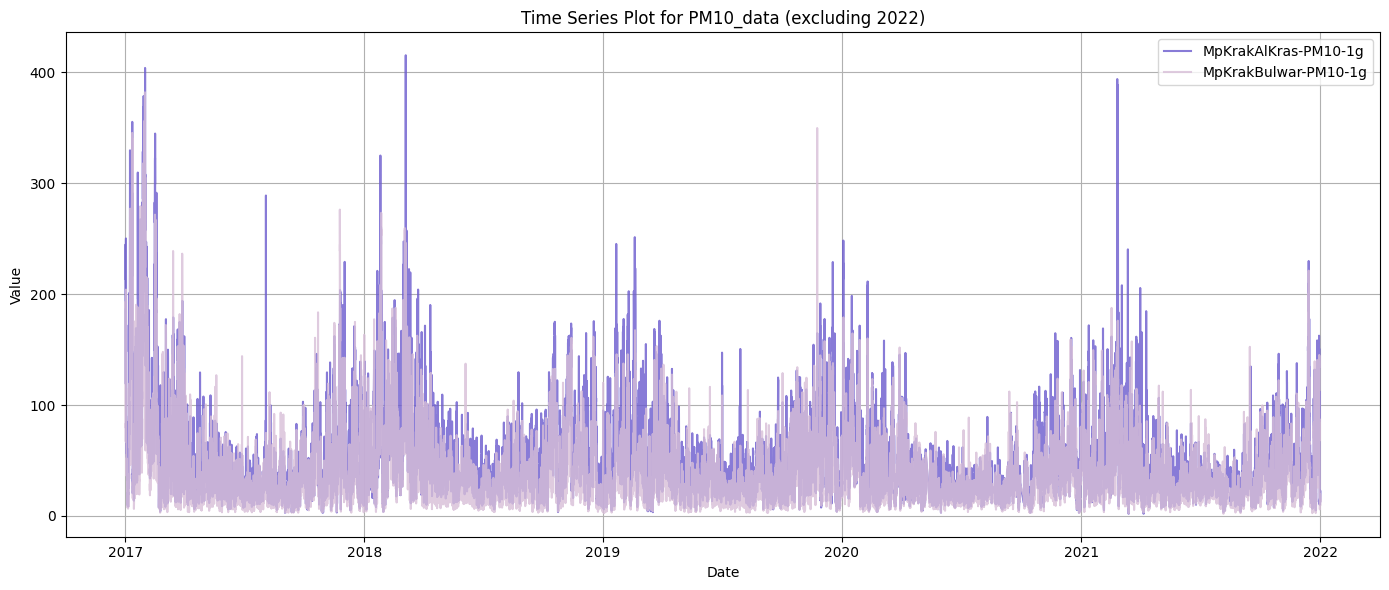

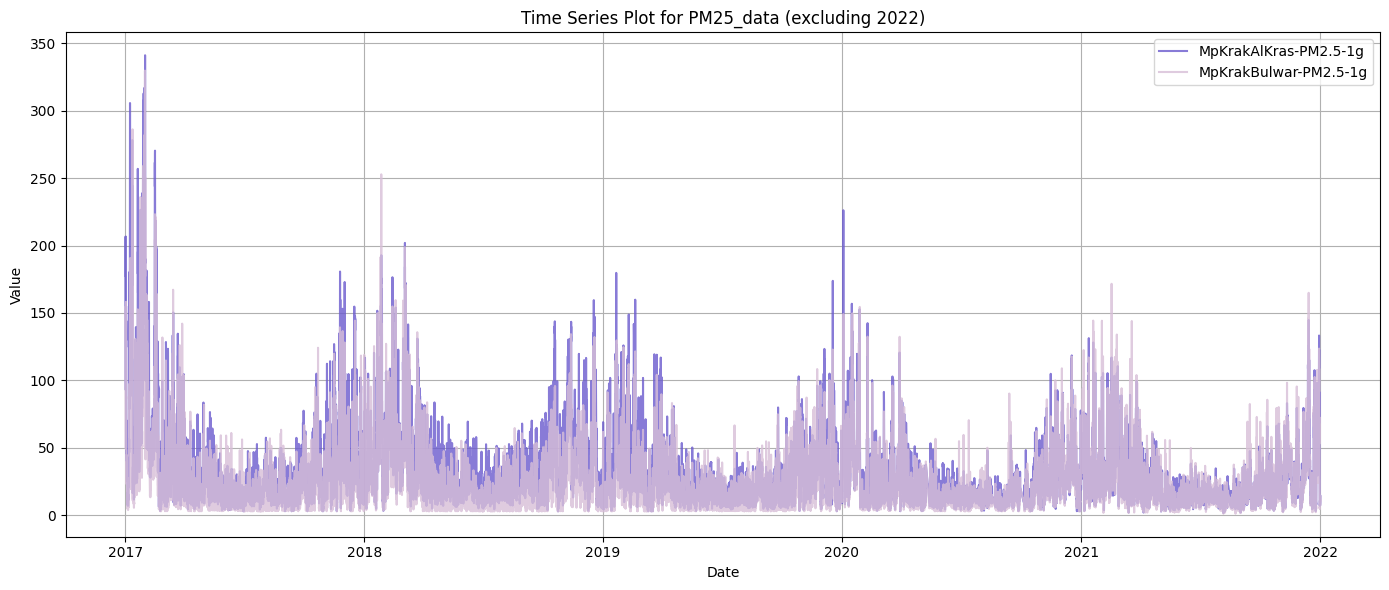

In [13]:
# Loop through the cleaned datasets again for plotting
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_out + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    plt.figure(figsize=(14, 6))
    
    for col in krak_columns:
        if 'MpKrakAlKras' in col:
            plt.plot(data.index, data[col], label=col, color='slateblue', alpha=0.8)  # Use the first color with alpha
        elif 'MpKrakBulwar' in col:
            plt.plot(data.index, data[col], label=col, color='thistle', alpha=0.8)  # Use the second color with alpha
        
    plt.title(f'Time Series Plot for {name} (excluding 2022)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    
    # Show the plot
    plt.show()

### Histograms

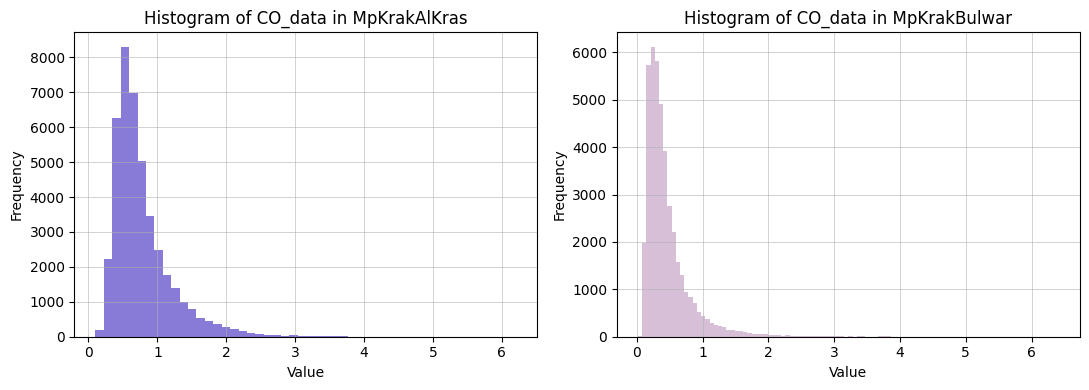

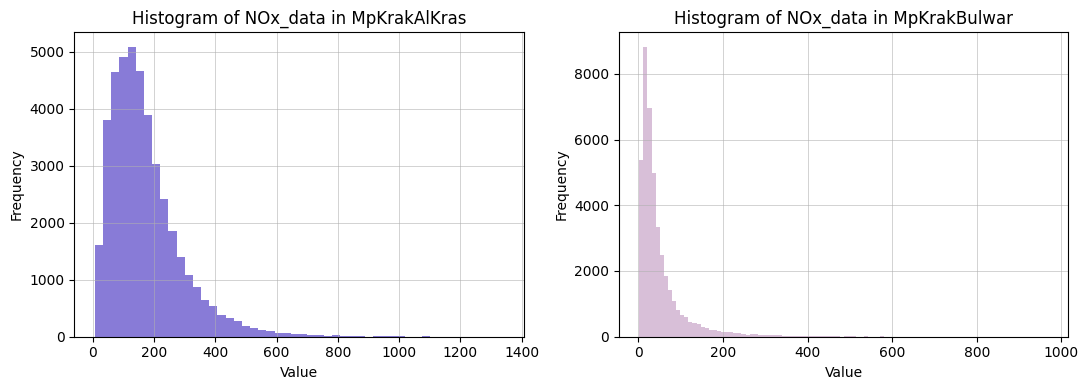

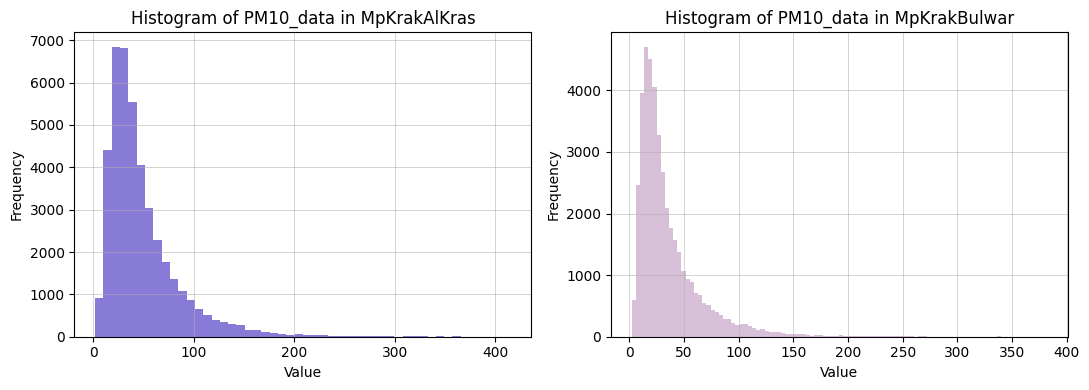

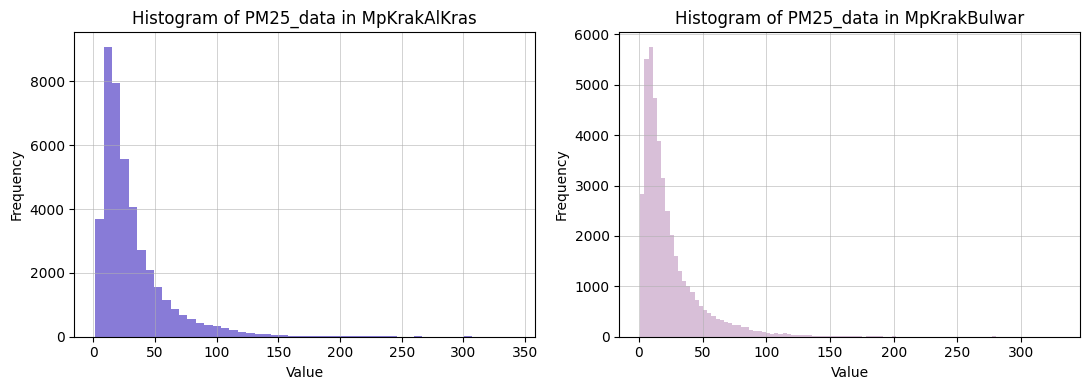

In [14]:
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_out + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    # Create subplots for histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
    
    # Left plot for MpKrakAlKras
    for col in krak_columns:
        if 'MpKrakAlKras' in col:
            axes[0].hist(data[col], bins=50, alpha=0.8, color='slateblue')
            axes[0].set_title(f'Histogram of {name} in MpKrakAlKras')
            axes[0].set_xlabel('Value')
            axes[0].set_ylabel('Frequency')
            axes[0].grid(linewidth=0.4)

    # Right plot for MpKrakBulwar
    for col in krak_columns:
        if 'MpKrakBulwar' in col:
            axes[1].hist(data[col], bins=100, alpha=1, color='thistle')
            axes[1].set_title(f'Histogram of {name} in MpKrakBulwar')
            axes[1].set_xlabel('Value')
            axes[1].set_ylabel('Frequency')
            axes[1].grid(linewidth=0.4)

    plt.tight_layout() 
    plt.show() 

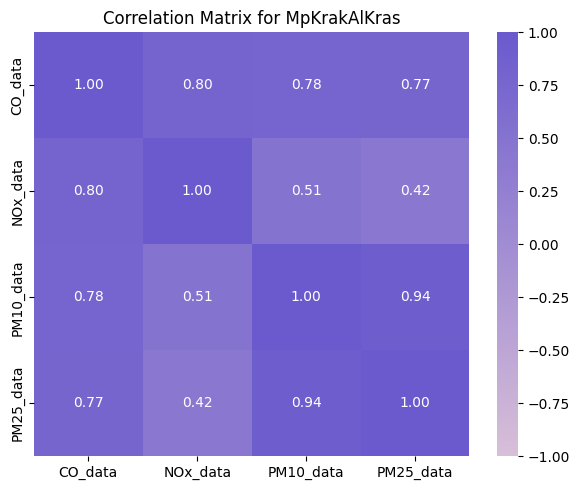

In [15]:
alkras_data = {}

# Loop through the cleaned datasets to extract the 'MpKrakAlKras' columns
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_out + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    alkras_column = [col for col in data.columns if 'MpKrakAlKras' in col]
    
    if alkras_column:
        alkras_data[name] = data[alkras_column[0]].dropna()  # Drop NaN values

# Create a DataFrame for the correlation analysis
alkras_df = pd.DataFrame(alkras_data)

# Calculate the correlation matrix
correlation_matrix = alkras_df.corr()

purple_cmap = LinearSegmentedColormap.from_list('my_purple', ['thistle', 'slateblue'])

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap=purple_cmap, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix for MpKrakAlKras')
plt.tight_layout()
plt.show()

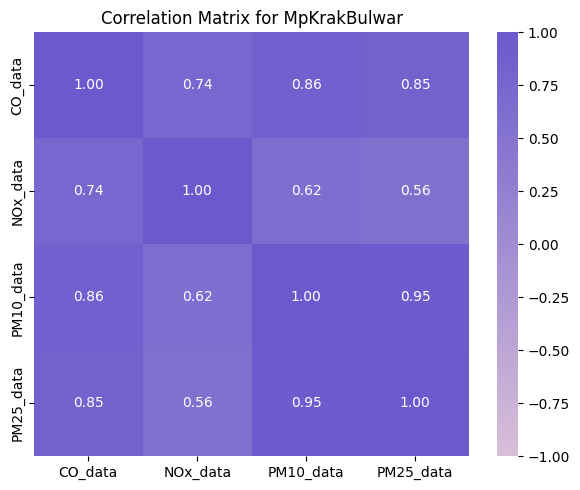

In [16]:
bulwar_data = {}

# Loop through the cleaned datasets to extract the 'MpKrakbulwar' columns
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_out + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    bulwar_column = [col for col in data.columns if 'MpKrakBulwar' in col]
    
    if bulwar_column:
        bulwar_data[name] = data[bulwar_column[0]].dropna()  # Drop NaN values

# Create a DataFrame for the correlation analysis
bulwar_df = pd.DataFrame(bulwar_data)

# Calculate the correlation matrix
correlation_matrix = bulwar_df.corr()

# Visualize the correlation matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap=purple_cmap, fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix for MpKrakBulwar')
plt.tight_layout()
plt.show()

Correlation matrix for CO_data:
              MpKrakAlKras  MpKrakBulwar
MpKrakAlKras       1.00000       0.80729
MpKrakBulwar       0.80729       1.00000


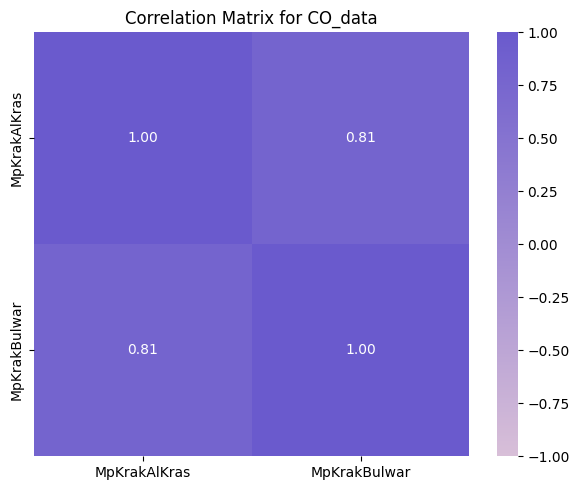

Correlation matrix for NOx_data:
              MpKrakAlKras  MpKrakBulwar
MpKrakAlKras      1.000000      0.692043
MpKrakBulwar      0.692043      1.000000


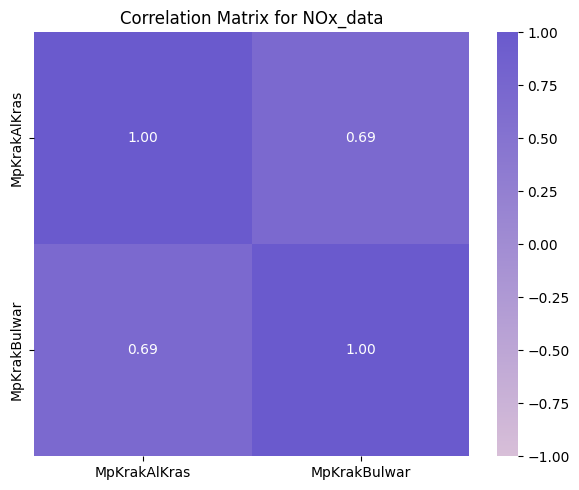

Correlation matrix for PM10_data:
              MpKrakAlKras  MpKrakBulwar
MpKrakAlKras      1.000000      0.870964
MpKrakBulwar      0.870964      1.000000


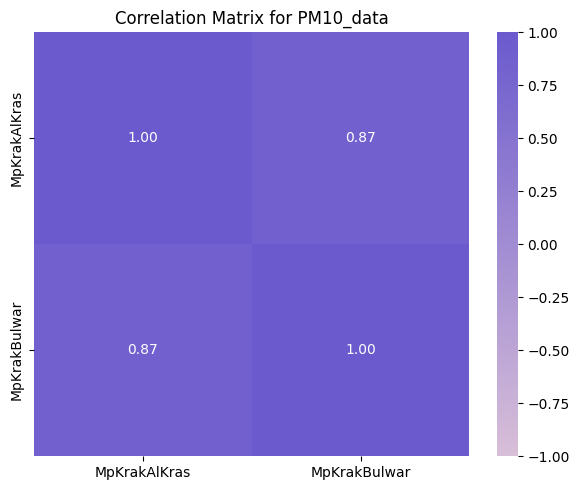

Correlation matrix for PM25_data:
              MpKrakAlKras  MpKrakBulwar
MpKrakAlKras      1.000000      0.903799
MpKrakBulwar      0.903799      1.000000


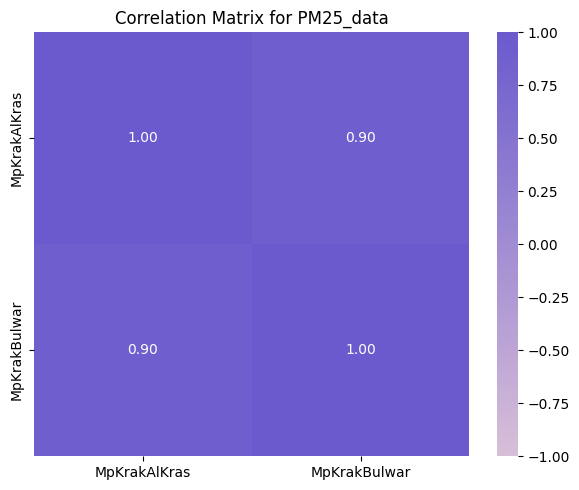

In [30]:
for name, file in cleaned_datasets.items():
    data = pd.read_csv(data_out + file)
    
    data['Time'] = pd.to_datetime(data['Time'])  # Convert the 'Time' column to datetime
    data.set_index('Time', inplace=True)  # Set the 'Time' column as the index

    # Exclude data past 2021
    data = data[(data.index < '2022-01-01')]

    # Identify columns of interest for correlation
    krak_columns = [col for col in data.columns if 'MpKrakAlKras' in col or 'MpKrakBulwar' in col]

    # Calculate the correlation matrix
    correlation_matrix = data[krak_columns].corr()

    # Rename columns and index for clarity in the heatmap
    renamed_columns = {col: 'MpKrakAlKras' if 'MpKrakAlKras' in col else 'MpKrakBulwar' for col in krak_columns}
    correlation_matrix.rename(columns=renamed_columns, index=renamed_columns, inplace=True)

    # Print the correlation coefficients
    print(f'Correlation matrix for {name}:')
    print(correlation_matrix)
    
    # Visualize the correlation matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap=purple_cmap, fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {name}')
    plt.tight_layout()
    plt.show()


### Trend Analysis

We chose PM2.5 at MpKrakAlKras to analyze for this section.

Regression results for MpKrakAlKras-PM2.5-1g:
Slope: -0.01
Intercept: 9778.97
R-squared: 0.06
P-value: 0.00
Standard Error: 0.00


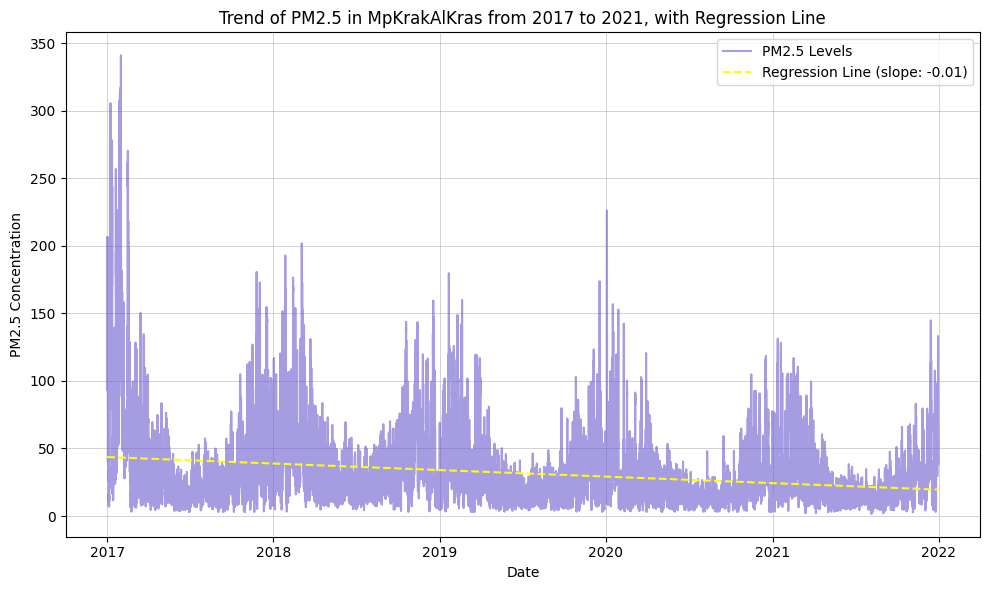

In [33]:
# PM2.5 at MpKrakAlKras
station_column = 'MpKrakAlKras-PM2.5-1g'

# Load the dataset
data = pd.read_csv(data_out + 'cleaned_PM25_data_KrakStations.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Filter for dates between 01/01/2017 and 31/12/2021
data = data[(data.index >= '2017-01-01') & (data.index <= '2021-12-31')]

# Select the pollutant data for analysis
pm25_data = data[station_column].dropna()

# Convert datetime index to ordinals (numbers) for regression
x_values = pm25_data.index.map(pd.Timestamp.toordinal)
y_values = pm25_data.values

# Perform Linear Regression
slope, intercept, r_value, p_value, std_err = linregress(x_values, y_values)
print(f"Regression results for {station_column}:")
print(f"Slope: {slope:.2f}")
print(f"Intercept: {intercept:.2f}")
print(f"R-squared: {r_value**2:.2f}")
print(f"P-value: {p_value:.2f}")
print(f"Standard Error: {std_err:.2f}")

# Create regression line values
regression_line = intercept + slope * x_values

# Time Series Plot with Regression Line
plt.figure(figsize=(10, 6))
plt.plot(pm25_data.index, y_values, label='PM2.5 Levels', color='slateblue', alpha=0.6)
plt.plot(pm25_data.index, regression_line, label=f'Regression Line (slope: {slope:.2f})', color='yellow', linestyle='--')
plt.title(f'Trend of PM2.5 in MpKrakAlKras from 2017 to 2021, with Regression Line')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.grid(linewidth=0.4)
plt.legend()
plt.tight_layout()
plt.show()


The negative slope of the regression line (slope: -0.01) indicates that the PM2.5 concentrations at this station are slightly decreasing over time, from 2017 to 2021.

The p-value is extremely low (close to zero), which indicates that the decreasing trend in PM2.5 levels is statistically significant. This means that the trend is unlikely to have occurred by chance.

The Mann-Kendall Test is a non-parametric statistical method used to detect the presence of a monotonic trend in time series data, such as environmental measurements, without assuming any particular distribution. It is commonly applied to assess whether a variable consistently increases or decreases over time.
https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm

In [ ]:
# Mann-Kendall Test
mk_test = mk.original_test(pm25_data.values)
print(f"Mann-Kendall Trend Test: {mk_test}")
print(f"Trend: {mk_test.trend}")
print(f"P-value: {mk_test.p}")
print(f"Slope: {mk_test.slope}")

The trend is decreasing, as shown by the 'trend': 'decreasing' output.
The test result is statistically significant with a p-value of 0.0, meaning the observed trend is highly unlikely to have occurred by chance.
The Z-value of -45.13 suggests a strong negative trend, with the data consistently decreasing over time.

The plot clearly shows seasonal variations in the PM2.5 levels over time, in addition to the overall decreasing trend.

It can be sees there are recurring spikes in PM2.5 concentrations, typically occurring during the winter months. These seasonal peaks are most likely associated with heating activities (e.g., burning fuel) and weather conditions like lower wind speeds and temperature inversions, which trap pollutants near the ground.

The periods of lower PM2.5 concentrations tend to occur during the summer months when heating is less common, and natural dispersion of pollutants is more effective.

The large spikes in PM2.5 concentrations visible in late 2016, 2017, 2018, and 2019 are likely due to seasonal pollution increases, such as heating, increased vehicle emissions, and less atmospheric circulation.

These seasonal fluctuations indicate that while the overall trend shows a slight decline (as per the regression line), certain seasonal factors lead to periodic increases in pollution, particularly in colder months.

The `seasonal_decompose` function from the statsmodels library is used to decompose time series data into three distinct components: trend, seasonality, and residual (noise). It supports both additive and multiplicative models, helping to isolate and visualize patterns in the data for better analysis and forecasting.
https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

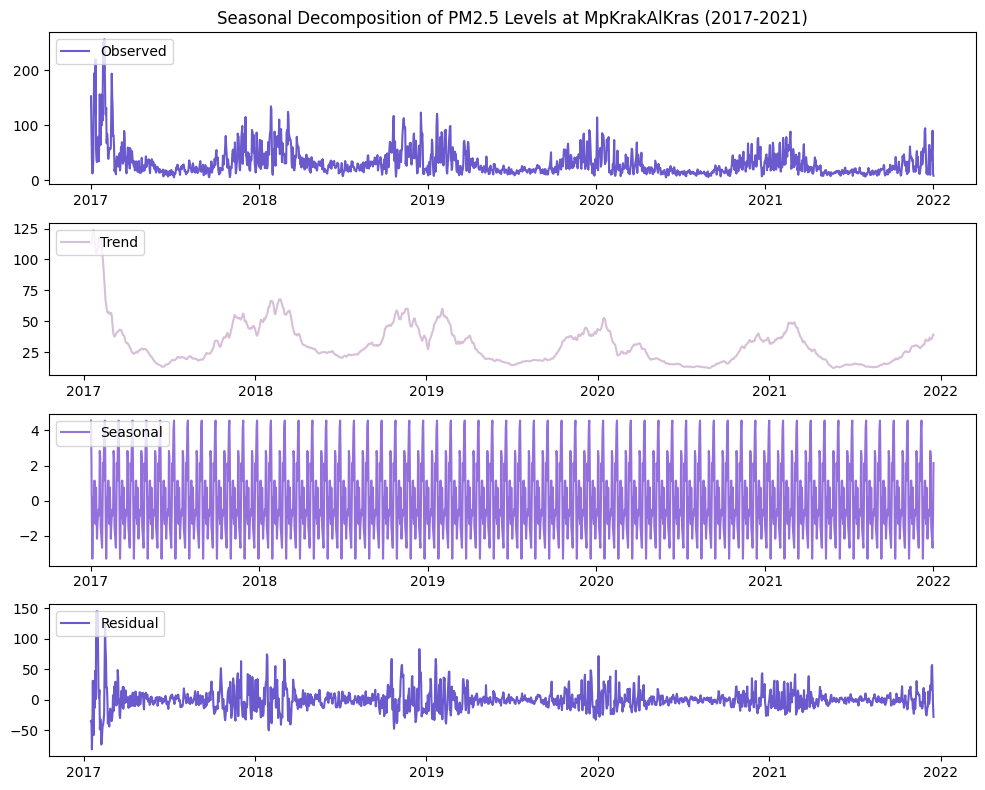

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the cleaned dataset
data = pd.read_csv(data_out + 'cleaned_PM25_data_KrakStations.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Filter for dates between 01/01/2017 and 31/12/2021
pm25_data = data['MpKrakAlKras-PM2.5-1g'].dropna()
pm25_data = pm25_data[(pm25_data.index >= '2017-01-01') & (pm25_data.index <= '2022-01-01')]

# Ensure the data is at a daily frequency by resampling
pm25_data = pm25_data.resample('D').mean()

# Fill missing values using interpolation
pm25_data_filled = pm25_data.interpolate()

# Perform seasonal decomposition (using an additive model)
# decomposition = seasonal_decompose(pm25_data_filled, model='additive')
decomposition = seasonal_decompose(pm25_data_filled, model='additive', period=30)


# Plot the decomposition
plt.figure(figsize=(10, 8))


plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='slateblue')
plt.legend(loc='upper left')
plt.title('Seasonal Decomposition of PM2.5 Levels at MpKrakAlKras (2017-2021)')  
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='thistle')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='mediumpurple')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='slateblue')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


The trend line indicates a decrease in PM2.5 levels, followed by smaller, periodic rises and falls. From 2019 onward, the trend stabilizes around a lower range. This reflects a slow improvement in air quality, though fluctuations still exist.

The seasonal component shows repeating cycles suggesting a recurring pattern every 30 units (approximately monthly).

To have a closer look in one year:

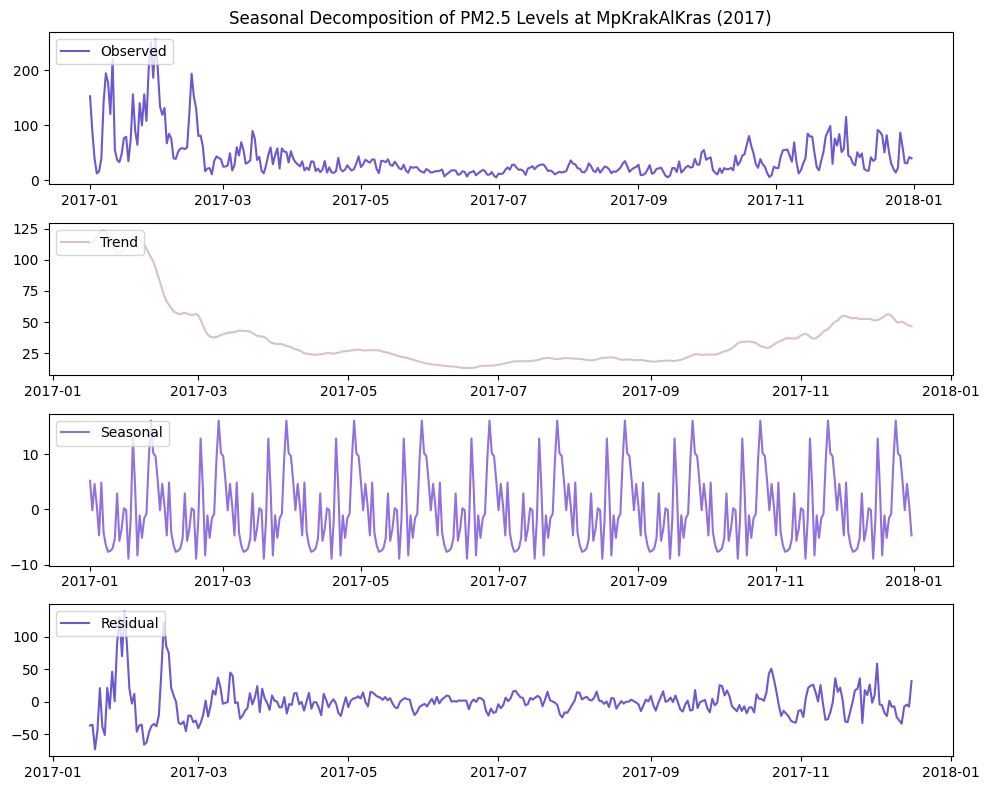

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the cleaned dataset
data = pd.read_csv(data_out + 'cleaned_PM25_data_KrakStations.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

# Filter for dates between 01/01/2017 and 31/12/2018
pm25_data = data['MpKrakAlKras-PM2.5-1g'].dropna()
pm25_data = pm25_data[(pm25_data.index >= '2017-01-01') & (pm25_data.index <= '2017-12-31')]

# Ensure the data is at a daily frequency by resampling
pm25_data = pm25_data.resample('D').mean()

# Fill missing values using interpolation
pm25_data_filled = pm25_data.interpolate()

# Perform seasonal decomposition (using an additive model)
# decomposition = seasonal_decompose(pm25_data_filled, model='additive')
decomposition = seasonal_decompose(pm25_data_filled, model='additive', period=30)


# Plot the decomposition
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='slateblue')
plt.title('Seasonal Decomposition of PM2.5 Levels at MpKrakAlKras (2017)')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='thistle')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='mediumpurple')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='slateblue')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
